In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.signal import find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [59]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def set_diagonal(pred):
    l = pred.shape[0]
    idx = np.arange(l)
    pred[idx[:-1], idx[1:]] = 0
    pred[idx[1:], idx[:-1]] = 0
    
    return pred


def quantile_norm(pred1, pred2):
    l = pred1.shape[0]
    pred1_diag = np.array([np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred2_diag = np.array([np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sorted = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sorted.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1,200), df_qn[1].values.reshape(-1,200)
    
    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l-i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn


def quantile_norm_multi(preds):
    return


def topdom(mat, size):
    padmat = np.pad(mat, size, mode='constant', constant_values=np.nan)
    dim = padmat.shape[0]
    signal = np.array([
        np.nanmean(padmat[i-size:i+size, i-size:i+size]) for i in range(dim)
    ][size:-size])
    
    return signal


def generate_dim(mindim, maxdim, numdim):
    mindim, maxdim = max(1, mindim), min(100, maxdim)
    return np.linspace(mindim, maxdim, num=numdim, dtype=int)


def get_tads(mat, sizes):
    signal = np.array([topdom(mat, i) for i in tqdm(sizes)])
    rows, idxs = [], []
    for i in range(len(signal)):
        idx = find_peaks(signal[i], prominence=(0.25, ))[0]
        row = np.full_like(idx, i)
        rows.append(row)
        idxs.append(idx)
    tads = np.array([
        np.concatenate(rows, axis=None), np.concatenate(idxs, axis=None)
    ])
    
    return tads


def tads_to_coords(tads, sizes):
    coords = np.array([
        tads[1] - sizes[tads[0]], tads[1] + sizes[tads[0]]
    ])
    
    return coords


def merge_coords(coords, sizes, close=5):
    df = pd.DataFrame({'x': coords[0], 'y': coords[1]})
    merged = df.groupby('x', as_index=False).agg({'y': 'max'})
    merged['s'] = (merged.y - merged.x) // 2
    merged = merged.sort_values(by=['x']).reset_index(drop=True)
    
    i = 0
    curx, cury, curs = merged.iloc[i]
    
    while i+1 < merged.shape[0]:
        x, y, s = merged.iloc[i+1]
        if s == curs:
            if abs(x - curx) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        else:
            if abs(s - curs) <= close and (abs(x - curx) <= close or abs(x - cury) <= close):
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        merged.iloc[i] = [curx, cury, curs]
    
    return merged.values.T


def get_tad_coords(mat1, mat2, mindim=10, maxdim=100, numdim=10, close=5):
    sizes = generate_dim(mindim, maxdim, numdim)
    tads1, tads2 = get_tads(mat1, sizes), get_tads(mat2, sizes)
    alltads = np.concatenate((tads1, tads2), axis=1)
    allcoords = tads_to_coords(alltads, sizes)
    coords = merge_coords(allcoords, sizes, close)
    
    return coords


def rank_coords(mat1, mat2, coords):
    xs, ys, ss, scores, absscores = [], [], [], [], []
    for i in range(coords.shape[1]):
        x, y, s = coords[:, i]
        area1, area2 = mat1[x:y, x:y], mat2[x:y, x:y]
        score = np.var(area1 - area2) * np.mean(area1 - area2)
        absscore = abs(score)
        xs.append(x)
        ys.append(y)
        ss.append(s)
        scores.append(score)
        absscores.append(absscore)
    df = pd.DataFrame({
        'x_coord': xs, 'y_coord': ys, 'window_size': ss,
        'diff_score': scores, 'abs_diff_score': absscores
    })
    df = df.sort_values(by=['abs_diff_score'], ignore_index=True, ascending=False)
    
    return df

In [19]:
%%time

chrom = 16
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'

pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred1, pred2 = set_diagonal(pred1), set_diagonal(pred2)
pred1_qn, pred2_qn = quantile_norm(pred1, pred2)

CPU times: user 4.69 s, sys: 2.36 s, total: 7.05 s
Wall time: 7.15 s


In [60]:
coords = get_tad_coords(pred1_qn, pred2_qn, numdim=25)
ranked = rank_coords(pred1_qn, pred2_qn, coords)
ranked

100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


,x_coord,y_coord,window_size,diff_score,abs_diff_score
0,2413,2447,17,-0.198183,0.198183
1,2395,2489,47,-0.188968,0.188968
2,5840,5876,18,0.186577,0.186577
3,1791,1825,17,0.174315,0.174315
4,4515,4561,23,0.153322,0.153322
...,...,...,...,...,...
524,384,554,85,-0.000075,0.000075
525,9135,9155,10,0.000055,0.000055
526,5695,5879,92,0.000043,0.000043
527,4395,4415,10,0.000032,0.000032


2413 2447 17
-0.1981825558899026


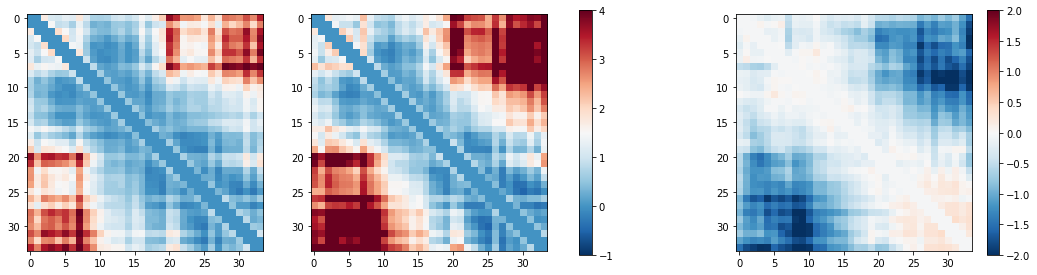

2395 2489 47
-0.18896790394111293


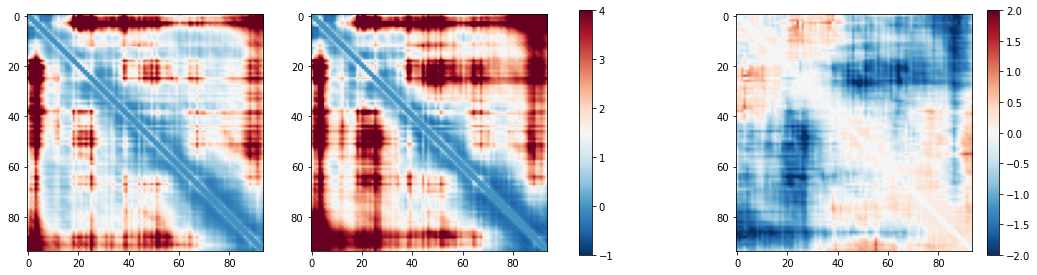

5840 5876 18
0.18657749781911


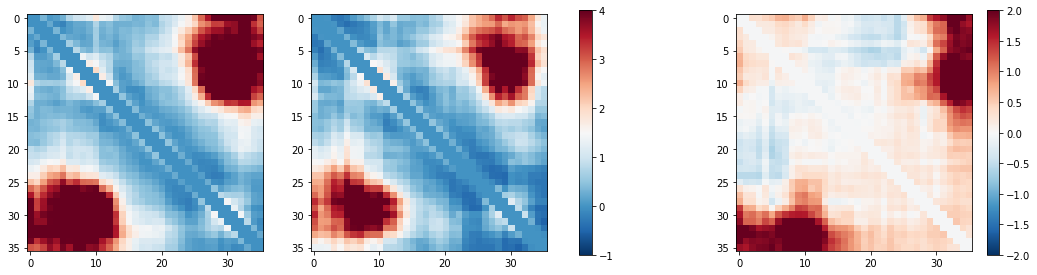

1791 1825 17
0.1743152811147414


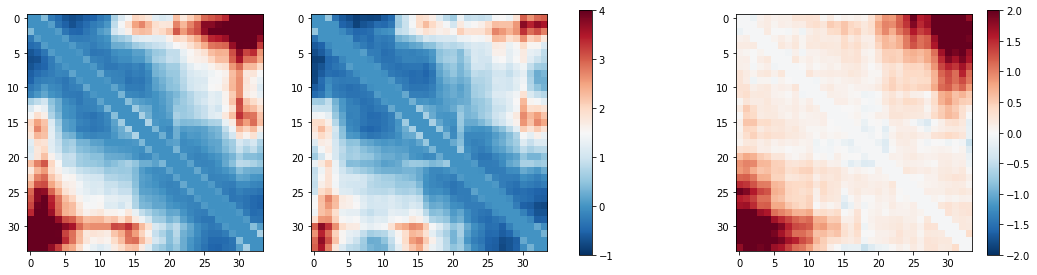

4515 4561 23
0.15332199660827275


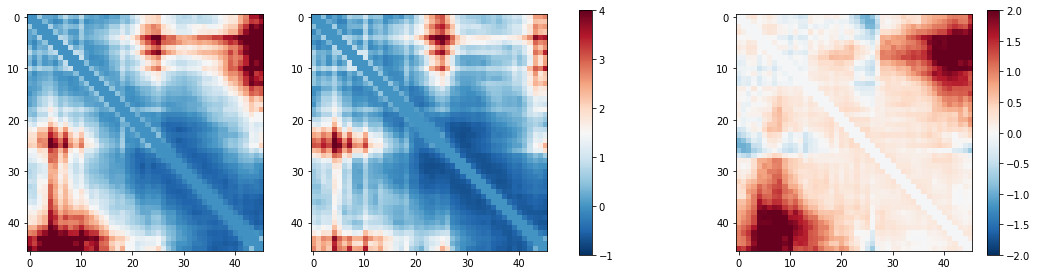

4514 4564 25
0.1422263475635479


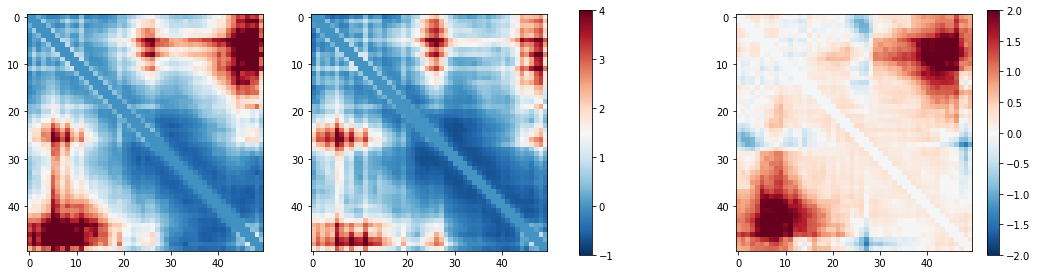

1785 1830 22
0.13692828445367938


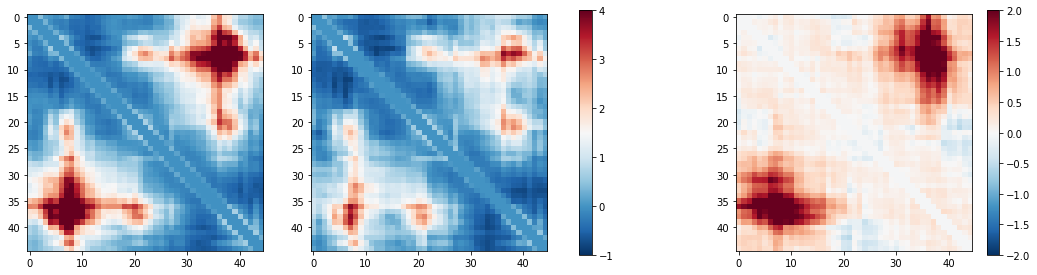

2415 2442 13
-0.1337289272620092


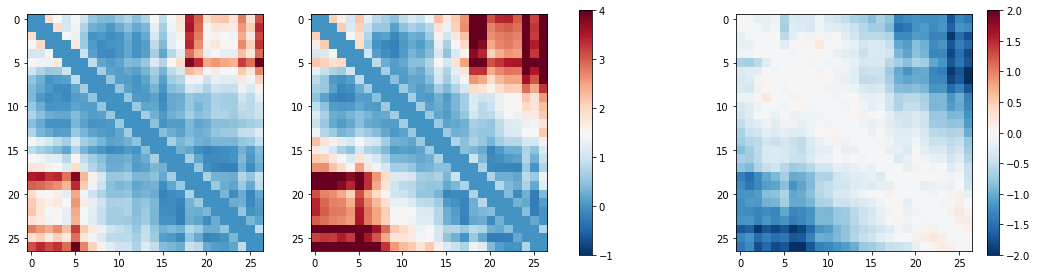

3815 3857 21
0.12345905199678471


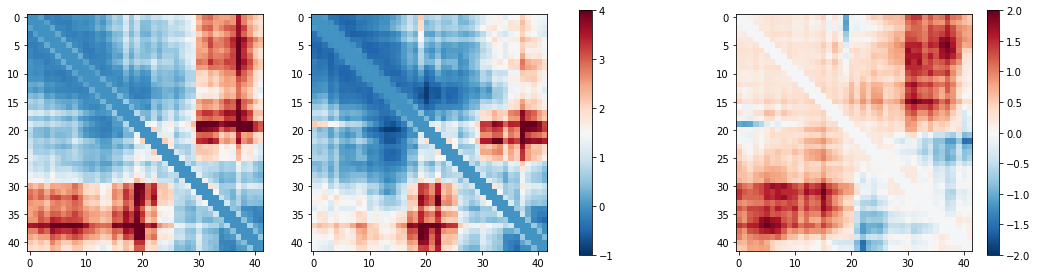

2393 2504 55
-0.12029345588336354


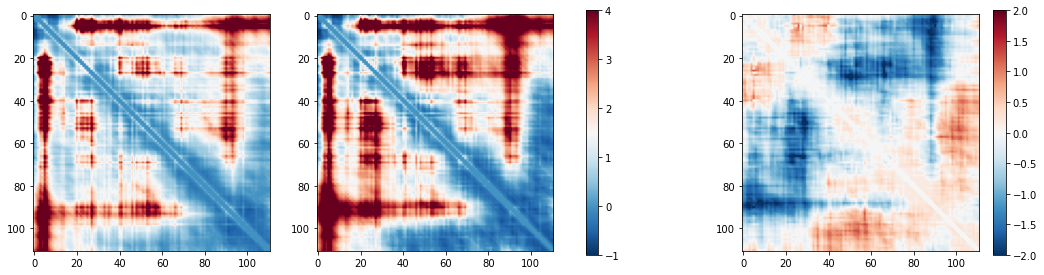

In [61]:
for i in range(10):
    x, y, s, score1, score2 = ranked.iloc[i]
    x, y, s = int(x), int(y), int(s)
    print(x, y, s)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    area1, area2 = pred1_qn[x:y, x:y], pred2_qn[x:y, x:y]
    print(np.var(area1 - area2) * np.mean(area1 - area2))
    im = axs[0].imshow(area1, cmap='RdBu_r', vmax=4, vmin=-1)
    im = axs[1].imshow(area2, cmap='RdBu_r', vmax=4, vmin=-1)
    fig.colorbar(im, ax=axs[:2].ravel().tolist(), shrink=0.75)
    im = axs[2].imshow(area1 - area2, cmap='RdBu_r', vmax=2, vmin=-2)
    fig.colorbar(im, ax=axs[2], shrink=0.75)
    
    plt.show()